# Imports

First, we'll import the necessary libraries.

In [2]:
import requests
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon

Next, we'll query the City of Philadelphia data via the ArcGIS REST API using the `requests` library. We'll also use the `json` library to parse the response.

Finally, we'll use the `geopandas` library to create a geodataframe from the response.

We have three different datasets to import from the City's ArcGIS server. These are:

### 1. Vacant Land

In [62]:
# Define the URL for the Vacant_Indicators_Land feature service
land_url = 'https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/Vacant_Indicators_Land/FeatureServer/0/query'

# Define the parameters for the Vacant_Indicators_Land API request
land_params = {
    'where': '1=1',
    'outFields': '*',
    'returnGeometry': 'true',
    'f': 'json'
}

# Make the Vacant_Indicators_Land API request
land_response = requests.get(land_url, params=land_params)

# Check if the Vacant_Indicators_Land request was successful
if land_response.status_code == 200:
    # Convert the Vacant_Indicators_Land JSON data to a geopandas geodataframe; convert to CRS 2272
    land_data = land_response.json()

    # convert the JSON data to a pandas dataframe
    land_df = pd.DataFrame(land_data['features'])

    # separate the attributes column into one column per attribute
    land_df = pd.concat([land_df.drop(['attributes'], axis=1), land_df['attributes'].apply(pd.Series)], axis=1)

    # make the `geometry` column a shapely geometry object
    land_df['geometry'] = land_df['geometry'].apply(lambda x: Polygon(x['rings'][0]))

    # convert the pandas dataframe to a geopandas geodataframe
    land_gdf = gpd.GeoDataFrame(land_df, geometry='geometry', crs='EPSG:2272')

else:
    print('Vacant_Indicators_Land Request failed with status code:', land_response.status_code)

Now we'll apply string cleaning to the OWNER1 and OWNER2 columns to identify public vs. private ownership.

In [70]:
# remove all punctuation from the OWNER1 and OWNER2 columns
land_gdf['OWNER1'] = land_gdf['OWNER1'].str.replace(r'[^\w\s]+', '')
land_gdf['OWNER2'] = land_gdf['OWNER2'].str.replace(r'[^\w\s]+', '')

# create a new column that combines the OWNER1 and OWNER2 columns according to the following rules:
# if OWNER1 is not null and OWNER2 is null, then the new column is OWNER1
# if OWNER1 is null and OWNER2 is not null, then the new column is OWNER2
# if OWNER2 starts with a preposition, then the new column is OWNER1 + OWNER2 separated by a space
# if OWNER2 does not start with a preposition, then the new column is OWNER2 + OWNER1 separated by a se


# define a function to check if a string starts with a preposition
def starts_with_preposition(string):
    prepositions = ['a', 'an', 'and', 'as', 'at', 'but', 'by', 'for', 'from', 'in', 'into', 'nor', 'of', 'on', 'or', 'so', 'the', 'to', 'up', 'yet']
    if string.split(' ')[0].lower() in prepositions:
        return True
    else:
        return False
    
# define a function to combine the OWNER1 and OWNER2 columns
def combine_owners(row):
    if pd.isnull(row['OWNER1']) and pd.isnull(row['OWNER2']):
        return None
    elif pd.isnull(row['OWNER1']) and not pd.isnull(row['OWNER2']):
        return row['OWNER2']
    elif not pd.isnull(row['OWNER1']) and pd.isnull(row['OWNER2']):
        return row['OWNER1']
    elif starts_with_preposition(row['OWNER2']):
        return row['OWNER1'] + ' ' + row['OWNER2']
    else:
        return row['OWNER2'] + '; ' + row['OWNER1']
    
# apply the combine_owners function to the land_gdf dataframe
land_gdf['OWNER'] = land_gdf.apply(combine_owners, axis=1)

# create a dictionary of public owner name typos and their correct spelling
public_owner_typos = {
                'PHILADELPHIA HOUSING AUTH' : 'PHILADELPHIA HOUSING AUTHORITY',
                'CITY OF PHILA' : 'CITY OF PHILADELPHIA',
                'DEPT OF PUBLC PROP; CITY OF PHILA' : 'CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROPERTY',
                'DEPT OF PUBLIC PROP; CITY OF PHILA' : 'CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROPERTY',
                'DEPT PUB PROP; CITY OF PHILA' : 'CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROPERTY',
                'REDEVELOPMENT AUTHORITY OF PHILA' : 'REDEVELOPMENT AUTHORITY OF PHILADELPHIA',
                'PHILA REDEVELOPMENT AUTH' : 'REDEVELOPMENT AUTHORITY OF PHILADELPHIA',
                'PHILADELPHIA LAND INVESTM' : 'PHILADELPHIA LAND INVESTMENT',
                'REDEVELOPMENT AUTHORITY O' : 'PHILADELPHIA REDEVELOPMENT AUTHORITY',
                'PHILADELPHIA REDEVELOPMEN' : 'PHILADELPHIA REDEVELOPMENT AUTHORITY',
                'PHILA HOUSING AUTHORITY' : 'PHILADELPHIA HOUSING AUTHORITY',
                'KENSINGTON HOUSING AUTHOR' : 'KENSINGTON HOUSING AUTHORITY',
                'DEVELOPMENT CORPORATION; PHILADELPHIA HOUSING' : 'PHILADELPHIA HOUSING DEVELOPMENT CORPORATION',
                'PHILA REDEVELOPMENT AUTHO' : 'REDEVELOPMENT AUTHORITY OF PHILADELPHIA',
                'DEPT OF PUB PROP; CITY OF PHILA' : 'CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROPERTY',
                'PHILA HOUSING DEV CORP' : 'PHILADELPHIA HOUSING DEVELOPMENT CORPORATION',
                'DEP OF PUB PROP; CITY OF PHILA' : 'CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROPERTY',
                'REDEVELOPMENT AUTHORITY' : 'REDEVELOPMENT AUTHORITY OF PHILADELPHIA',
                'COMMONWEALTH OF PA' : 'COMMONWEALTH OF PENNSYLVANIA',
                'COMMONWEALTH OF PENNA' : 'COMMONWEALTH OF PENNSYLVANIA',
                'DEPT OF PUBLIC PROP; CITY OF PHILADELPHIA' : 'CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROPERTY',
                'DEPT PUBLIC PROP R E DIV; CITY OF PHILA' : 'CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROPERTY',
                'PUBLIC PROP DIV; CITY OF PHILA' : 'CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROPERTY',
                'PUBLIC PROP REAL ESTATE; CITY OF PHILA' : 'CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROPERTY',
                'REAL ESTATE DIV; CITY OF PHILA' : 'CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROPERTY',
                'REAL ESTATE DIVISION; CITY OF PHILA' : 'CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROPERTY',
                'URBAN DEVELOPMENT; SECRETARY OF HOUSING' : 'SECRETARY OF HOUSING AND URBAN DEVELOPMENT',
                'URBAN DEVELOPMENT; SECRETARY OF HOUSING AND' : 'SECRETARY OF HOUSING AND URBAN DEVELOPMENT',
                'REDEVELOPMENT AUTH' : 'REDEVELOPMENT AUTHORITY OF PHILADELPHIA'
}

public_owner_typos = {value: key for key, value in public_owner_typos.items()}

# using the public_owner_typos dictionary, replace any typos in the OWNER column with the correct spelling
land_gdf['OWNER'] = land_gdf['OWNER'].replace(public_owner_typos)

# strip leading and trailing whitespace from the OWNER column
land_gdf['OWNER'] = land_gdf['OWNER'].str.strip()

# define the following as a list of public owner names

public_owners = ['PHILADELPHIA LAND BANK',
                'PHILADELPHIA HOUSING AUTH',
                'CITY OF PHILA',
                'REDEVELOPMENT AUTHORITY OF PHILADELPHIA',
                'CITY OF PHILADELPHIA',
                'DEPT OF PUBLC PROP; CITY OF PHILA',
                'DEPT OF PUBLIC PROP; CITY OF PHILA',
                'DEPT PUB PROP; CITY OF PHILA',
                'REDEVELOPMENT AUTHORITY OF PHILA',
                'PHILA REDEVELOPMENT AUTH',
                'PHILADELPHIA LAND INVESTM',
                'REDEVELOPMENT AUTHORITY O',
                'PHILADELPHIA REDEVELOPMEN',
                'PHILA HOUSING AUTHORITY',
                'KENSINGTON HOUSING AUTHOR',
                'DEVELOPMENT CORPORATION; PHILADELPHIA HOUSING',
                'PHILA REDEVELOPMENT AUTHO',
                'DEPT OF PUB PROP; CITY OF PHILA',
                'PHILA HOUSING DEV CORP',
                'DEP OF PUB PROP; CITY OF PHILA',
                'REDEVELOPMENT AUTHORITY',
                'COMMONWEALTH OF PA',
                'COMMONWEALTH OF PENNA',
                'DEPT OF PUBLIC PROP; CITY OF PHILADELPHIA',
                'DEPT PUBLIC PROP R E DIV; CITY OF PHILA',
                'PUBLIC PROP DIV; CITY OF PHILA',
                'PUBLIC PROP REAL ESTATE; CITY OF PHILA',
                'REAL ESTATE DIV; CITY OF PHILA',
                'REAL ESTATE DIVISION; CITY OF PHILA',
                'URBAN DEVELOPMENT; SECRETARY OF HOUSING'
                'URBAN DEVELOPMENT; SECRETARY OF HOUSING AND',
                'PHILADELPHIA REDEVELOPMENT AUTHORITY',
                'PHILADELPHIA REDEVELOPMENT AUTH',
                'PHILADELPHIA HOUSING AUTHORITY',
                'PHILADELPHIA LAND BANK',
                'REDEVELOPMENT AUTHORITY OF PHILADELPHIA',
                'PHILADELPHIA HOUSING AUTHORITY',
                'CITY OF PHILADELPHIA',
                'CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROPERTY',
                'REDEVELOPMENT AUTHORITY OF PHILADELPHIA',
                'PHILADELPHIA LAND INVESTMENT',
                'PHILADELPHIA REDEVELOPMENT AUTHORITY',
                'PHILADELPHIA HOUSING AUTHORITY',
                'KENSINGTON HOUSING AUTHORITY',
                'PHILADELPHIA HOUSING DEVELOPMENT CORPORATION',
                'REDEVELOPMENT AUTHORITY OF PHILADELPHIA',
                'CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROPERTY',
                'PHILADELPHIA HOUSING DEVELOPMENT CORPORATION',
                'CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROPERTY',
                'REDEVELOPMENT AUTHORITY OF PHILADELPHIA',
                'COMMONWEALTH OF PENNSYLVANIA',
                'CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROPERTY',
                'SECRETARY OF HOUSING AND URBAN DEVELOPMENT',
                'REDEVELOPMENT AUTHORITY OF PHILADELPHIA',
                'PHILADELPHIA LAND INVESTMENT',
                'CITY OF PHILADELPHIA DEPARTMENT OF PUBLIC PROPERTY'
]

# create a new column called 'public_owner' that is True if the OWNER column is in the public_owners list
land_gdf['public_owner'] = land_gdf['OWNER'].isin(public_owners)

C:\Users\Nissim\AppData\Local\Temp\ipykernel_40148\3348072445.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  land_gdf['OWNER1'] = land_gdf['OWNER1'].str.replace(r'[^\w\s]+', '')
C:\Users\Nissim\AppData\Local\Temp\ipykernel_40148\3348072445.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  land_gdf['OWNER2'] = land_gdf['OWNER2'].str.replace(r'[^\w\s]+', '')


In [71]:
# create a table tallying the number of public and private parcels by top owners
top_pub_owners = land_gdf.groupby('OWNER')['public_owner'].value_counts().unstack().fillna(0).sort_values(by=True, ascending=False).head(15)

top_pub_owners

public_owner,False,True
OWNER,,
PHILADELPHIA LAND BANK,0.0,166.0
CITY OF PHILA,0.0,130.0
PHILADELPHIA HOUSING AUTH,0.0,81.0
DEPT OF PUBLC PROP; CITY OF PHILA,0.0,33.0
DEPT OF PUBLIC PROP; CITY OF PHILA,0.0,30.0
DEPT PUB PROP; CITY OF PHILA,0.0,28.0
REDEVELOPMENT AUTHORITY OF PHILA,0.0,15.0
PHILA REDEVELOPMENT AUTH,0.0,12.0
PHILADELPHIA LAND INVESTM,0.0,8.0


In [72]:
# create a table tallying the number of private parcels by top owners
top_priv_owners = land_gdf.groupby('OWNER')['public_owner'].value_counts().unstack().fillna(0).sort_values(by=False, ascending=True).head(15)

top_priv_owners

public_owner,False,True
OWNER,,
PHILADELPHIA HOUSING AUTH,0.0,81.0
DEPT OF PUBLIC PROP; CITY OF PHILADELPHIA,0.0,1.0
DEPT PUB PROP; CITY OF PHILA,0.0,28.0
DEPT PUBLIC PROP R E DIV; CITY OF PHILA,0.0,1.0
PUBLIC PROP DIV; CITY OF PHILA,0.0,1.0
PUBLIC PROP REAL ESTATE; CITY OF PHILA,0.0,1.0
COMMONWEALTH OF PENNA,0.0,1.0
DEPT OF PUBLIC PROP; CITY OF PHILA,0.0,30.0
KENSINGTON HOUSING AUTHOR,0.0,2.0


<AxesSubplot:>

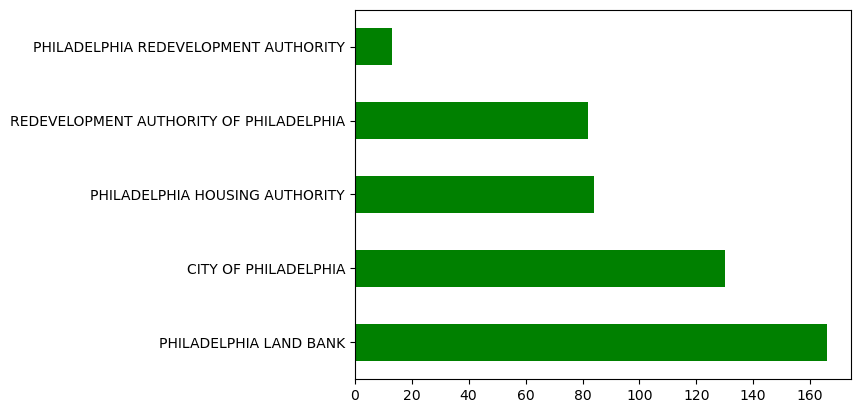

In [59]:
# plot the top 20 public owners
land_gdf_draft[land_gdf_draft['public_owner'] == True]['OWNER'].value_counts().head(30).plot(kind='barh', color='green')

In [60]:
# list the strings of the top 30 public owners
land_gdf_draft[land_gdf_draft['public_owner'] == True]['OWNER'].value_counts().head(30).index.tolist()

['PHILADELPHIA LAND BANK',
 'CITY OF PHILADELPHIA',
 'PHILADELPHIA HOUSING AUTHORITY',
 'REDEVELOPMENT AUTHORITY OF PHILADELPHIA',
 'PHILADELPHIA REDEVELOPMENT AUTHORITY']

<AxesSubplot:>

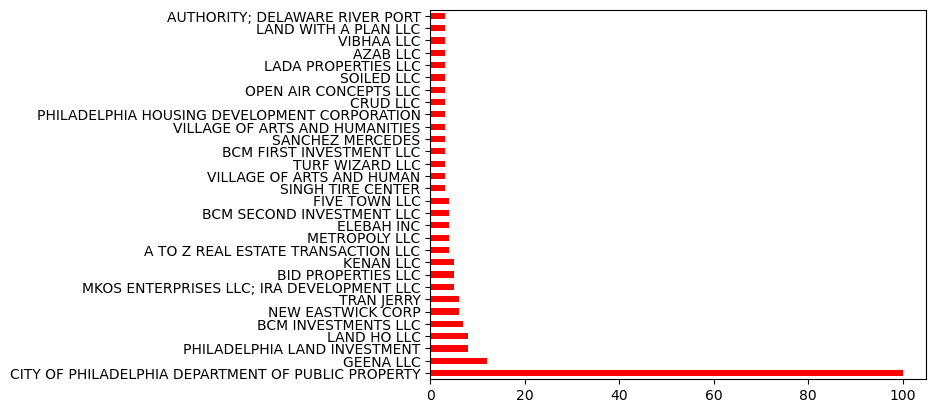

In [61]:
# plot the top 30 private owners
land_gdf_draft[land_gdf_draft['public_owner'] == False]['OWNER'].value_counts().head(30).plot(kind='barh', color='red')

In [32]:
# print a scrollable table of all the owners and the public owner status
land_gdf_draft[['OWNER', 'public_owner']].drop_duplicates().sort_values(by='OWNER').style.set_properties(**{'text-align': 'left'})

,OWNER,public_owner
881,1105 AS LLC,False
965,111 E CUMBERLAND LLC,False
1955,1206 DAUPHIN LLC,False
182,1210 FENIX PROPERTIES LLC,False
1884,121719 E COLUMBIA AVE LL,False
108,1219 W SOMERSET LLC,False
234,1221 LEHIGH LLC,False
1495,1232 N MYRTLEWOOD ST LLC,False
1785,1300 S 33 LLC,False
749,1426 N 7TH LLC,False


In [24]:
land_gdf.head()

# filter land_gdf to include only the following columns:
# geometry, ADDRESS, OWNER1, OWNER2, BLDG_DESC, OPA_ID, COUNCILDISTRICT, ZIPCODE
land_gdf = land_gdf[['geometry', 'ADDRESS', 'OWNER1', 'OWNER2', 'BLDG_DESC', 'OPA_ID', 'COUNCILDISTRICT', 'ZIPCODE']]

land_gdf.head()

# concatenate owner1 and owner2 columns, separated by a semicolon
land_gdf['OWNER'] = land_gdf['OWNER1'] + ';' + land_gdf['OWNER2']

# drop owner1 and owner2 columns
land_gdf = land_gdf.drop(['OWNER1', 'OWNER2'], axis=1)


In [7]:
land_gdf[1:10]

,geometry,ADDRESS,BLDG_DESC,OPA_ID,COUNCILDISTRICT,ZIPCODE,OWNER
1,"POLYGON ((-8374222.271 4861610.724, -8374210.2...",633 N 53RD ST,VAC LAND RES < ACRE,442316810,3,19131,REDEVELOPMENT AUTHORITY;OF PHILADELPHIA
2,"POLYGON ((-8366581.336 4864542.085, -8366581.3...",2424 N MOLE ST,VAC LAND RES < ACRE,161064101,5,19132,REDEVELOPMENT AUTHORITY;OF PHILADELPHIA
3,"POLYGON ((-8364770.853 4863189.028, -8364774.0...",437 ARLINGTON ST,VAC LAND RES < ACRE,183194500,7,19122,NaN
4,"POLYGON ((-8366371.622 4865213.014, -8366390.5...",2735 N HICKS ST,VAC LAND RES < ACRE,111168200,8,19132,HERBERT MITCHELL;VICTORIA
5,"POLYGON ((-8376282.763 4872708.245, -8376315.8...",271 HILLSIDE AVE,VAC LAND RES < ACRE,212376000,4,19128,NaN
6,"POLYGON ((-8377092.072 4851588.494, -8377112.9...",2506 S 82ND ST,VAC LAND RES < ACRE,405818503,2,19153,NaN
7,"POLYGON ((-8367292.894 4871358.116, -8367301.0...",5313 BELFIELD AVE,VAC LAND RES < ACRE,122158700,8,19144,NaN
8,"POLYGON ((-8375912.807 4861085.573, -8375894.6...",252 N 61ST ST,ROW 2 STY MASONRY,341145900,4,19139,NaN
9,"POLYGON ((-8368871.869 4856441.385, -8368876.0...",2041 REED ST,VAC LAND COMM. < ACRE,885396760,2,19146,NaN


### 2. Vacant Buildings

In [53]:
# Define the URL for the Vacant_Indicators_Bldg feature service
bldg_url = 'https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/Vacant_Indicators_Bldg/FeatureServer/0/query'

# Define the parameters for the Vacant_Indicators_Bldg API request
bldg_params = {
    'where': '1=1',
    'outFields': '*',
    'returnGeometry': 'true',
    'f': 'json'
}

# Make the Vacant_Indicators_Bldg API request
bldg_response = requests.get(bldg_url, params=bldg_params)

# Check if the Vacant_Indicators_Bldg request was successful
if bldg_response.status_code == 200:
    # Convert the Vacant_Indicators_Bldg JSON data to a geopandas geodataframe
    bldg_data = bldg_response.json()

    # convert the JSON data to a pandas dataframe
    bldg_df = pd.DataFrame(bldg_data['features'])

    # separate the attributes column into one column per attribute
    bldg_df = pd.concat([bldg_df.drop(['attributes'], axis=1), bldg_df['attributes'].apply(pd.Series)], axis=1)

    # make the `geometry` column a shapely geometry object
    bldg_df['geometry'] = bldg_df['geometry'].apply(lambda x: Polygon(x['rings'][0]))

    # convert the pandas dataframe to a geopandas geodataframe
    bldg_gdf = gpd.GeoDataFrame(bldg_df, geometry='geometry', crs='EPSG:2272')

else:
    print('Vacant_Indicators_Bldg Request failed with status code:', bldg_response.status_code)

### 3. PHS Community Landcare Parcels

In [5]:
# Define the URL for the Vacant_Indicators_phs_landcare feature service
phs_landcare_url = 'https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/PHS_CommunityLandcare/FeatureServer/0/query'

# Define the parameters for the Vacant_Indicators_phs_landcare API request
phs_landcare_params = {
    'where': '1=1',
    'outFields': '*',
    'returnGeometry': 'true',
    'f': 'json'
}

# Make the Vacant_Indicators_phs_landcare API request
phs_landcare_response = requests.get(phs_landcare_url, params=phs_landcare_params)

# Check if the Vacant_Indicators_phs_landcare request was successful
if phs_landcare_response.status_code == 200:
    # Convert the Vacant_Indicators_phs_landcare JSON data to a geopandas geodataframe
    phs_landcare_data = phs_landcare_response.json()

    # convert the JSON data to a pandas dataframe
    phs_landcare_df = pd.DataFrame(phs_landcare_data['features'])

    # separate the attributes column into one column per attribute
    phs_landcare_df = pd.concat([phs_landcare_df.drop(['attributes'], axis=1), phs_landcare_df['attributes'].apply(pd.Series)], axis=1)

    # make the `geometry` column a shapely geometry object
    phs_landcare_df['geometry'] = phs_landcare_df['geometry'].apply(lambda x: Polygon(x['rings'][0]))

    # convert the pandas dataframe to a geopandas geodataframe
    phs_landcare_gdf = gpd.GeoDataFrame(phs_landcare_df, geometry='geometry', crs='EPSG:2272')

else:
    print('PHS_CommunityLandcare Request failed with status code:', phs_landcare_response.status_code)

Now we need to import two more datasets from the City's Carto database (SQL).

### 1. L&I Violations

In [4]:
import requests
import datetime

# Calculate one year ago from today's date
one_year_ago = (datetime.datetime.now() - datetime.timedelta(days=365)).strftime("%Y-%m-%d")

# Create the SQL query
li_sql_query = "SELECT service_request_id, subject, status, service_name, service_code, lat, lon FROM public_cases_fc WHERE requested_datetime >= '{}'".format(one_year_ago)

# Make the GET request
li_response = requests.get("https://phl.carto.com/api/v2/sql", params={"q": li_sql_query})

# Get the data
li_data = li_response.json()["rows"]

# convert li_data to a pandas dataframe
li_df = pd.DataFrame(li_data)

# Convert the data to a geopandas dataframe
li_gdf = gpd.GeoDataFrame(li_df, geometry=gpd.points_from_xy(li_df.lon, li_df.lat), crs='EPSG:2272')

# drop the lat and lon columns
li_gdf.drop(['lat', 'lon'], axis=1, inplace=True)


Remaining to pull in:
1. Council Districts
2. Neighborhoods
3. RCOs

# Gun Crimes

For our gun crime kernel density estimate, we have two steps:

### 1. Import gun crime data from the City's Carto database (SQL):

In [8]:
# Modify the SQL query
guncrimes_sql_query = "SELECT text_general_code, dispatch_date, point_x, point_y FROM incidents_part1_part2 WHERE dispatch_date_time >= '{}' AND text_general_code".format(one_year_ago)

# Make the GET request
guncrimes_response = requests.get("https://phl.carto.com/api/v2/sql", params={"q": guncrimes_sql_query})

# Get the data
guncrimes_data = guncrimes_response.json()["rows"]

# convert guncrimes_data to a pandas dataframe
guncrimes_df = pd.DataFrame(guncrimes_data)



In [9]:
guncrimes_df.head()

,text_general_code,dispatch_date,point_x,point_y
0,Thefts,2022-08-22,-75.247645,39.886841
1,Thefts,2022-09-10,-75.046249,40.033620
2,Thefts,2022-09-09,-75.046249,40.033620
3,Thefts,2022-09-09,-75.046249,40.033620
4,Thefts,2022-09-07,-75.046249,40.033620


In [ ]:

# Convert the data to a geopandas dataframe
guncrimes_gdf = gpd.GeoDataFrame(guncrimes_df, geometry=gpd.points_from_xy(guncrimes_df.point_x, guncrimes_df.point_y), crs='EPSG:2272')

# drop the lat and lon columns
guncrimes_gdf.drop(['point_x', 'point_y'], axis=1, inplace=True)

### 2. Create a kernel density estimate from the gun crime data:

In [23]:
import sklearn
from sklearn.neighbors import KernelDensity
import numpy as np
import matplotlib.pyplot as plt

# Get X and Y coordinates of well points
x_sk = guncrime_gdf["geometry"].x
y_sk = guncrime_gdf["geometry"].y

# Get minimum and maximum coordinate values of well points
min_x_sk, min_y_sk, max_x_sk, max_y_sk = guncrime_gdf.total_bounds

# Create a cell mesh grid
# Horizontal and vertical cell counts should be the same
XX_sk, YY_sk = np.mgrid[min_x_sk:max_x_sk:100j, min_y_sk:max_y_sk:100j]

# Create 2-D array of the coordinates (paired) of each cell in the mesh grid
positions_sk = np.vstack([XX_sk.ravel(), YY_sk.ravel()]).T

# Create 2-D array of the coordinate values of the well points
Xtrain_sk = np.vstack([x_sk, y_sk]).T

# Get kernel density estimator (can change parameters as desired)
kde_sk = KernelDensity(bandwidth = 5280, metric = 'euclidean', kernel = 'gaussian', algorithm = 'auto')

# Fit kernel density estimator to wells coordinates
kde_sk.fit(Xtrain_sk)

# Evaluate the estimator on coordinate pairs
Z_sk = np.exp(kde_sk.score_samples(positions_sk))

# Reshape the data to fit mesh grid
Z_sk = Z_sk.reshape(XX_sk.shape)

# Plot data
#fig, ax = plt.subplots(1, 1, figsize = (10, 10))
#ax.imshow(np.rot90(Z_sk), cmap = "RdPu", extent = [min_x_sk, max_x_sk, min_y_sk, max_y_sk])
#ax.plot(x_sk, y_sk, 'k.', markersize = 2, alpha = 0.1)
#plt.show()

import rasterio

def export_kde_raster(Z, XX, YY, min_x, max_x, min_y, max_y, proj, filename):
    '''Export and save a kernel density raster.'''

    # Flip array vertically and rotate 270 degrees
    Z_export = np.rot90(np.flip(Z, 0), 3)

    # Get resolution
    xres = (max_x - min_x) / len(XX)
    yres = (max_y - min_y) / len(YY)

    # Set transform
    transform = rasterio.Affine.translation(min_x - xres / 2, min_y - yres / 2) * rasterio.Affine.scale(xres, yres)

    # Export array as raster
    with rasterio.open(
            filename,
            mode = "w",
            driver = "GTiff",
            height = Z_export.shape[0],
            width = Z_export.shape[1],
            count = 1,
            dtype = Z_export.dtype,
            crs = proj,
            transform = transform,
    ) as new_dataset:
            new_dataset.write(Z_export, 1)

# Export raster
export_kde_raster(Z = Z_sk, XX = XX_sk, YY = YY_sk,
                  min_x = min_x_sk, max_x = max_x_sk, min_y = min_y_sk, max_y = max_y_sk,
                  proj = 2272, filename = "C:/Users/Nissim/Desktop/Vacant Lots Project/guncrime_kde_rast.tif")

from matplotlib import pyplot

kde_rast = rasterio.open("C:/Users/Nissim/Desktop/Vacant Lots Project/guncrime_kde_rast.tif")

from rasterio.plot import show


Reclassify data into percentiles.

In [ ]:
import rasterstats

vac_lots_gdf3['rast_val'] = rasterstats.point_query(vac_lots_gdf3, "C:/Users/Nissim/Desktop/Vacant Lots Project/guncrime_kde_rast.tif")

import mapclassify

# Define the number of classes
n_classes = 10

# Create a quantiles classifier
classifier = mapclassify.Quantiles.make(k = n_classes)

# Classify the data
vac_lots_gdf3['rast_val'] = vac_lots_gdf3[['rast_val']].apply(classifier)

# scale from 1-5 instead of 0-4
vac_lots_gdf3['rast_val'] = vac_lots_gdf3['rast_val'].replace([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ['90th Percentile', '80th Percentile', '70th Percentile', '60th Percentile', '50th Percentile', '40th Percentile', '30th Percentile', '20th Percentile', '10th Percentile', '0th Percentile'])